In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv


## Reading the train set

In [2]:
df = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv')
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [3]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,8d135da0b55b8c88,component composite coating,composition,H01
freq,1,152,24,2186


It can be seen that there are 36,473 rows, out of whcih 733 unique anchors are present, 106 unique contexts, and 29,340 targets. Some anchors are very common, with "component composite coating" for instance appearing 152 times.

In [4]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [5]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

## Tokenization
Transformers uses a `dataset` object for sorting a dataset.

In [6]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)
print(ds)

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})


We cannot pass texts directly into the model. A deep learning model expects numbers as inputs, not English sentences. So we need to do the following -
1. Tokenization: Split each text up into words (or tokens)
2. Numericalization: Convert each word (or token) into a number

In [7]:
model_nm = 'microsoft/deberta-v3-small'

`AutoTokenizer` will create a tokenizer appropriate for a given model -

In [8]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [9]:
'''
Example of how the tokenizer splits a text into
'tokens' (which are like words, but can be sub-word pieces,
as shown below):
'''

tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

Uncommon words will be split into pieces. The start of a new world is represented by `_`

In [10]:
# Another example

tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [11]:
# Function which tokenizes the inputs
def tok_func(x):
    return tokz(x["input"])

# To run this quickly in parallel on every row in our dataset, use `map`
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

This adds a new item to our dataset called `input_ids`. For instance here is the input and IDs for the first row of our data.

In [12]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

So, what are those IDs and where do they come from? The secret is that there's a list called `vocab` in the tokenizer which contains a unique integer for every possible token string. We can look up like this, for instance to find the token for the word "of" -

In [13]:
tokz.vocab['▁of']

265

Finally, we need to prepare our labels. Transforms always assumes that your labels has the column name `labels`, but in our dataset it's currently `score`. Therefore, we need to rename it -

In [14]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

## Creating a validation set

In [15]:
eval_df = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


In [16]:
# Validation set
def f(x):
    return -3*x**2 + 2*x + 20

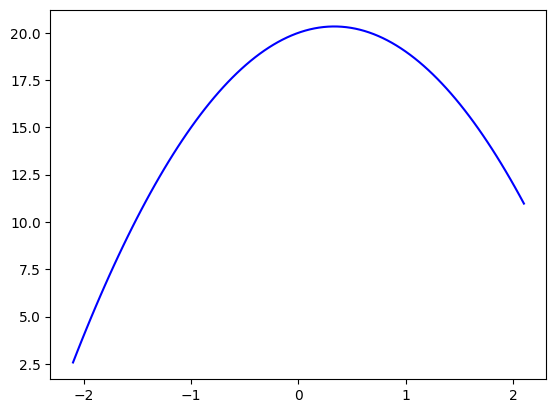

In [17]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='b'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

plot_function(f)

In [18]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [19]:
# Here's a function `add_noise` that adds some random variation to an array:
def noise(x, scale):
    return normal(scale=scale, size=x.shape)

def add_noise(x, mult, add):
    return x * (1+noise(x,mult)) + noise(x,add)

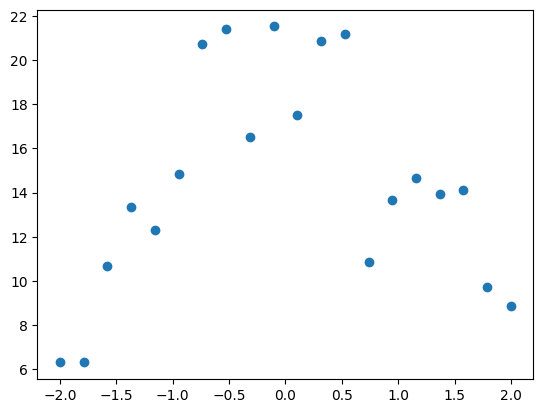

In [20]:
# simulation of measurements evenly distributed over time

x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

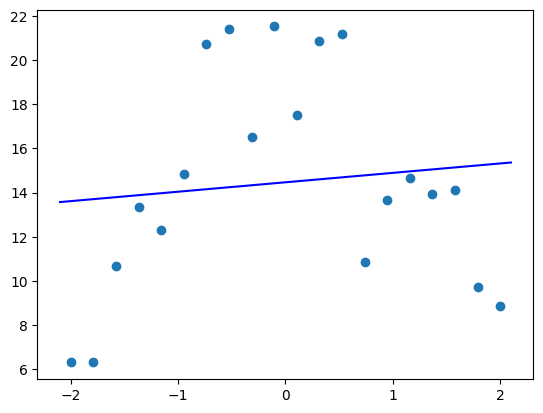

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

plot_poly(1)

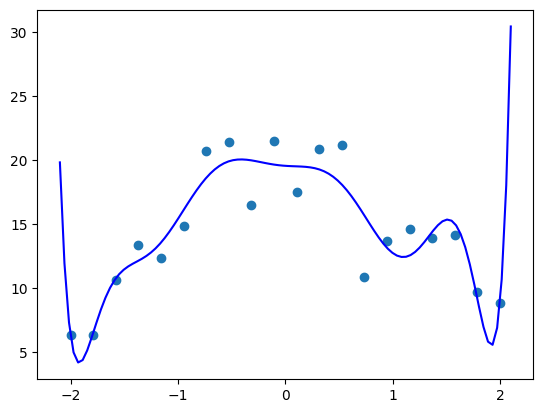

In [22]:
plot_poly(10)

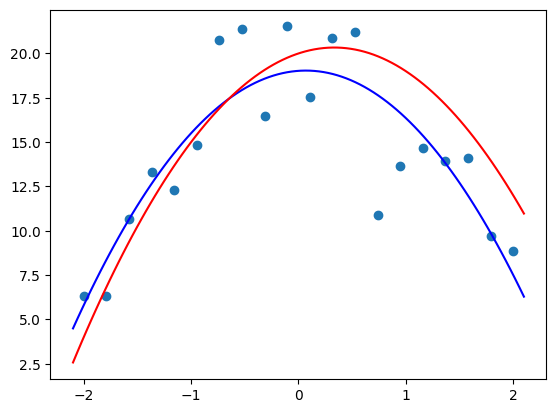

In [23]:
plot_poly(2)
plot_function(f, color='r')

Transformers uses `DatasetDict` for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use `train_test_split`

In [24]:
dds = tok_ds.train_test_split(0.25, seed=42)
print(dds)

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})


In [25]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Transformers expects metrics to be returned as a `dict`, since that way the trainer knows what label to use -

In [26]:
def corr_d(eval_pred):
    return {'pearson': corr(*eval_pred)}

## Training

In [27]:
from transformers import TrainingArguments,Trainer

# these are the 3 values which needs to be changed for different models

bs = 128
epochs = 4
# the most important hyperparameter is the learning rate.
lr = 8e-5

2024-04-23 01:48:13.075844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 01:48:13.075973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 01:48:13.350734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We can now create our model, and `Trainer`, which is a class which combines the data and model together (just like `Learner` in fastai) -

In [28]:
args = TrainingArguments('outputs',
                         learning_rate=lr,
                         warmup_ratio=0.1,
                         lr_scheduler_type='cosine',
                         fp16=True,

    evaluation_strategy="epoch",
                         per_device_train_batch_size=bs,
                         per_device_eval_batch_size=bs*2,

    num_train_epochs=epochs,
                         weight_decay=0.01,
                         report_to='none')

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, 
                                                           num_labels=1)

trainer = Trainer(model, args, 
                  train_dataset=dds['train'], 
                  eval_dataset=dds['test'],
                  tokenizer=tokz, 
                  compute_metrics=corr_d)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batc

In [30]:
def corr(x,y): 
    return np.corrcoef(x,y)[0][1]

def corr_d(eval_pred): 
    return {'pearson': corr(*eval_pred)}

In [31]:
trainer.train();

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.041019,0.771117
2,No log,0.023752,0.808276
3,No log,0.024122,0.824754
4,No log,0.023436,0.826664


In [32]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.56520742],
       [ 0.67624944],
       [ 0.50206828],
       [ 0.30037236],
       [-0.00658771],
       [ 0.51465994],
       [ 0.52730817],
       [ 0.05278526],
       [ 0.29904383],
       [ 1.08946526],
       [ 0.21530379],
       [ 0.26234066],
       [ 0.72277504],
       [ 0.81286883],
       [ 0.74298429],
       [ 0.47356951],
       [ 0.32725695],
       [-0.05477966],
       [ 0.65391809],
       [ 0.33917561],
       [ 0.37296659],
       [ 0.25024578],
       [ 0.11161976],
       [ 0.21611455],
       [ 0.59626722],
       [-0.04290827],
       [-0.04281251],
       [-0.02869337],
       [-0.04908544],
       [ 0.69936091],
       [ 0.35609609],
       [ 0.05889322],
       [ 0.70987159],
       [ 0.50248224],
       [ 0.42226505],
       [ 0.22324952]])

Some predictions are out of bound. The below code will help fix that.

In [33]:
preds = np.clip(preds, 0, 1)
preds

array([[0.56520742],
       [0.67624944],
       [0.50206828],
       [0.30037236],
       [0.        ],
       [0.51465994],
       [0.52730817],
       [0.05278526],
       [0.29904383],
       [1.        ],
       [0.21530379],
       [0.26234066],
       [0.72277504],
       [0.81286883],
       [0.74298429],
       [0.47356951],
       [0.32725695],
       [0.        ],
       [0.65391809],
       [0.33917561],
       [0.37296659],
       [0.25024578],
       [0.11161976],
       [0.21611455],
       [0.59626722],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.69936091],
       [0.35609609],
       [0.05889322],
       [0.70987159],
       [0.50248224],
       [0.42226505],
       [0.22324952]])

## Creating the submission file

In [34]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1033